# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [38]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer, Normalizer, StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### 0.1 Loading and Inspecting Data

In [39]:
# load in population and customers data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [40]:
# Load attribute data
attributes_desc = pd.read_excel('./DIAS Information Levels - Attributes 2017.xlsx', header = 1)
attributes_values = pd.read_excel('./DIAS Attributes - Values 2017.xlsx', header = 1)

In [41]:
# Inspect azdias data
print(azdias.shape)
print(azdias.head())

(891221, 366)
      LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  910215        -1         NaN       NaN          NaN          NaN   
1  910220        -1         9.0       0.0          NaN          NaN   
2  910225        -1         9.0      17.0          NaN          NaN   
3  910226         2         1.0      13.0          NaN          NaN   
4  910241        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                   NaN                  NaN   
1          NaN          NaN                  21.0                 11.0   
2          NaN          NaN                  17.0                 10.0   
3          NaN          NaN                  13.0                  1.0   
4          NaN          NaN                  14.0                  3.0   

          ...           VHN  VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  \
0         ...           NaN       Na

In [11]:
# Inspect customers data
print(customers.shape)
print(customers.head())

(191652, 369)
      LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0    9626         2         1.0      10.0          NaN          NaN   
1    9628        -1         9.0      11.0          NaN          NaN   
2  143872        -1         1.0       6.0          NaN          NaN   
3  143873         1         1.0       8.0          NaN          NaN   
4  143874        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                  10.0                  1.0   
1          NaN          NaN                   NaN                  NaN   
2          NaN          NaN                   0.0                  1.0   
3          NaN          NaN                   8.0                  0.0   
4          NaN          NaN                  14.0                  7.0   

          ...           VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  WOHNLAGE  \
0         ...               2.0      

### 0.2 Data Cleaning

Next, I will clean the data by handling the warning, making sure both data sets use the same columns, handle unknown values, take care of missing values and lastly by scaling the features. 

#### 0.2.1 Handling the Warning

In [12]:
# When loading the data we noticed that there are two columns with missing values
# Identify columns with mixed data type (18 + 19)
print(azdias.iloc[:,18:20].columns)
print(customers.iloc[:,18:20].columns)

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')
Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')


In [13]:
# Find unique values per column
print(azdias['CAMEO_INTL_2015'].unique())
print(customers['CAMEO_INTL_2015'].unique())

print(azdias['CAMEO_DEUG_2015'].unique())
print(customers['CAMEO_DEUG_2015'].unique())

[nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44' '35'
 '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45' 'XX']
[13.0 nan 34.0 24.0 41.0 23.0 15.0 55.0 14.0 22.0 43.0 51.0 33.0 25.0 44.0
 54.0 32.0 12.0 35.0 31.0 45.0 52.0 '45' '25' '55' '51' '14' '54' '43' '22'
 '15' '24' '35' '23' '12' '44' '41' '52' '31' '13' '34' '32' '33' 'XX']
[nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X']
[1.0 nan 5.0 4.0 7.0 3.0 9.0 2.0 6.0 8.0 '6' '3' '8' '9' '2' '4' '1' '7'
 '5' 'X']


There seem to be two issues leading to potential data type problems.
* There are X and XX values in both columns (string)
* There seem to be both floats and integers (e.g 3.0 vs 3)

Therefore, all X / XX will be transformed to NaNs and all integers will be transformed to floats.

In [14]:
warning_columns = ['CAMEO_INTL_2015', 'CAMEO_DEUG_2015']
azdias[warning_columns] = azdias[warning_columns].replace(['X', 'XX'], np.NaN).astype(float)
customers[warning_columns] = customers[warning_columns].replace(['X', 'XX'], np.NaN).astype(float)

#### 0.2.2 Common columns

In [15]:
# Create list column names in each data set
features_with_values = attributes_values['Attribute'].unique().tolist()
azdias_columns = azdias.columns.tolist()
customers_columns = azdias.columns.tolist()

# Create set with commo columns
common_columns = set(features_with_values) & set(azdias_columns) & set(customers_columns)

In [16]:
# Only keep common columns
azdias = azdias[azdias.columns.intersection(common_columns)]
customers = customers[customers.columns.intersection(common_columns)]

#### 0.2.3 Unknow values

Many of the values translate to unknown values according to the attribute values table. The goal is to replace these unknown values with NaNs. 

In [17]:
# Fill up missing attributes
attributes_values['Attribute'] = attributes_values['Attribute'].ffill()
attributes_values.head(10)

# Create column value dictionary
#feature_value_dict = {k: list(v) for k,v in attributes_values.groupby('Attribute')['Value']}

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,AGER_TYP,NaN,0,no classification possible
NaN,AGER_TYP,NaN,1,passive elderly
NaN,AGER_TYP,NaN,2,cultural elderly
NaN,AGER_TYP,NaN,3,experience-driven elderly
NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
NaN,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
NaN,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
NaN,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
NaN,ALTERSKATEGORIE_GROB,NaN,4,> 60 years


In [18]:
# Find unknown values
attributes_values_unknown = attributes_values[attributes_values["Meaning"] == "unknown"]
attributes_values_unknown.head()

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
NaN,ANREDE_KZ,gender,"-1, 0",unknown
NaN,BALLRAUM,distance to next urban centre,-1,unknown
NaN,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown


In [19]:
# Write function that replaces the unknown value with nan
def replace_unknowns_with_nan(value, unknown_values):
    """Replaces unknown values with nan"""
    if value in unknown_values:
        return np.nan
    else:
        return value

# Write function that replaces all unknown values with nan across all columns
def replace_unknown_values(df, unknown_attributes_values, verbose=False):
    """ Replaces unknown values with nan """
   

    for attribute in attributes_values_unknown.Attribute:
        
        # Return list with values translating to unknown.
        unknown_values = attributes_values_unknown[attributes_values_unknown["Attribute"] == attribute]["Value"]
        unknown_values = unknown_values.astype(str).str.cat(sep = ",")
        unknown_values = [[int(x) for x in unknown_values.split(",")]]
        
        if verbose:
            print("Replacing {} to NaN in Attribute {}".format(unknown_values, attribute))
        if attribute in df.columns:
            df[attribute] = df[attribute].apply(replace_unknowns_with_nan, args=(unknown_values))
    
    return df

In [20]:
azdias = replace_unknown_values(azdias, attributes_values_unknown, verbose=True)

Replacing [[-1]] to NaN in Attribute AGER_TYP


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Replacing [[-1, 0]] to NaN in Attribute ALTERSKATEGORIE_GROB
Replacing [[-1, 0]] to NaN in Attribute ANREDE_KZ
Replacing [[-1]] to NaN in Attribute BALLRAUM
Replacing [[-1]] to NaN in Attribute BIP_FLAG
Replacing [[-1]] to NaN in Attribute CAMEO_DEUG_2015
Replacing [[-1]] to NaN in Attribute CAMEO_DEUINTL_2015
Replacing [[0]] to NaN in Attribute CJT_GESAMTTYP
Replacing [[-1]] to NaN in Attribute D19_KK_KUNDENTYP
Replacing [[-1]] to NaN in Attribute EWDICHTE
Replacing [[-1]] to NaN in Attribute FINANZTYP
Replacing [[-1]] to NaN in Attribute FINANZ_ANLEGER
Replacing [[-1]] to NaN in Attribute FINANZ_HAUSBAUER
Replacing [[-1]] to NaN in Attribute FINANZ_MINIMALIST
Replacing [[-1]] to NaN in Attribute FINANZ_SPARER
Replacing [[-1]] to NaN in Attribute FINANZ_UNAUFFAELLIGER
Replacing [[-1]] to NaN in Attribute FINANZ_VORSORGER
Replacing [[-1, 0]] to NaN in Attribute GEBAEUDETYP
Replacing [[-1, 0]] to NaN in Attribute GEOSCORE_KLS7
Replacing [[-1, 0]] to NaN in Attribute HAUSHALTSSTRUKTUR
Re

In [21]:
customers = replace_unknown_values(customers, attributes_values_unknown, verbose=True)

Replacing [[-1]] to NaN in Attribute AGER_TYP


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Replacing [[-1, 0]] to NaN in Attribute ALTERSKATEGORIE_GROB
Replacing [[-1, 0]] to NaN in Attribute ANREDE_KZ
Replacing [[-1]] to NaN in Attribute BALLRAUM
Replacing [[-1]] to NaN in Attribute BIP_FLAG
Replacing [[-1]] to NaN in Attribute CAMEO_DEUG_2015
Replacing [[-1]] to NaN in Attribute CAMEO_DEUINTL_2015
Replacing [[0]] to NaN in Attribute CJT_GESAMTTYP
Replacing [[-1]] to NaN in Attribute D19_KK_KUNDENTYP
Replacing [[-1]] to NaN in Attribute EWDICHTE
Replacing [[-1]] to NaN in Attribute FINANZTYP
Replacing [[-1]] to NaN in Attribute FINANZ_ANLEGER
Replacing [[-1]] to NaN in Attribute FINANZ_HAUSBAUER
Replacing [[-1]] to NaN in Attribute FINANZ_MINIMALIST
Replacing [[-1]] to NaN in Attribute FINANZ_SPARER
Replacing [[-1]] to NaN in Attribute FINANZ_UNAUFFAELLIGER
Replacing [[-1]] to NaN in Attribute FINANZ_VORSORGER
Replacing [[-1, 0]] to NaN in Attribute GEBAEUDETYP
Replacing [[-1, 0]] to NaN in Attribute GEOSCORE_KLS7
Replacing [[-1, 0]] to NaN in Attribute HAUSHALTSSTRUKTUR
Re

### 0.3 Missing Values

In [22]:
# Function to sort columns by share of missing values
def get_missing_share_df (df):
    ''' Calculate the share of missing values per column and return data frame '''
    
    missing_share = df.isna().mean().round(4)
    df_missing_share = pd.DataFrame({"Attribute": df.columns, "Missing_Share": missing_share}).reset_index(drop=True)

    return df_missing_share

In [23]:
def compare_missing_share_plot(df_1, df_2, threshold=0, figsize=(10,70)):
    """
    Takes in two dataframes and plots a barchart comparing two dataframes
    features and percentage of missing values based on a threshold percentage given
    """
    fig = plt.figure(figsize=figsize)
    fig.suptitle("Missing Data per Attribute")

    ax = fig.add_subplot(121)
    ax.set_title("Azdias")
    sns.barplot(y="Attribute", x="Missing_Share", 
                data=df_1[df_1.Missing_Share>threshold], ax=ax)

    ax = fig.add_subplot(122)
    ax.set_title("Customer")
    sns.barplot(y="Attribute", x="Missing_Share", 
                data=df_2[df_2.Missing_Share>threshold], ax=ax)

    fig.tight_layout(rect=[0, 0.03, 1, 0.975])

    plt.show()

In [24]:
azdias_missing_share = get_missing_share_df(azdias)
customers_missing_share = get_missing_share_df(customers)

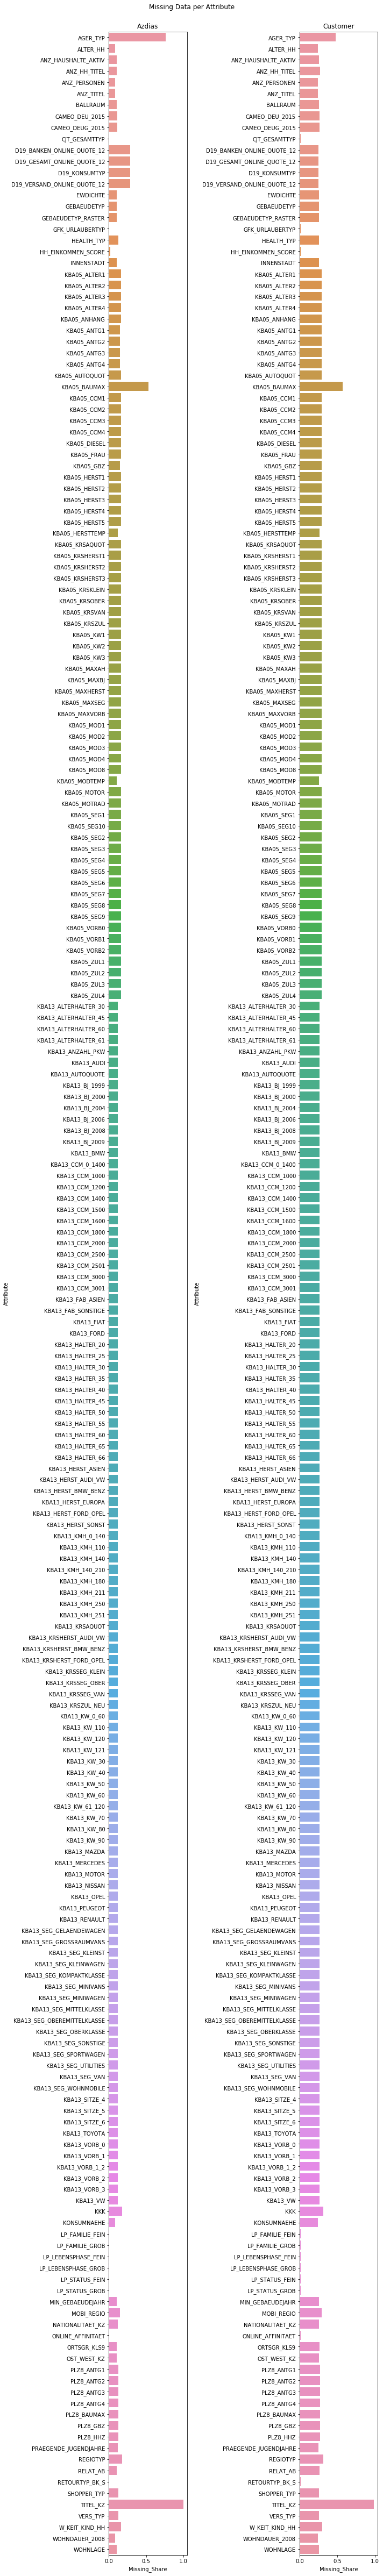

In [25]:
compare_missing_share_plot(azdias_missing_share, customers_missing_share, threshold=0)

Here - Some text about the insight.

In [26]:
print(azdias_missing_share.sort_values(by='Missing_Share', ascending=False).head(20))

                       Attribute  Missing_Share
264                     TITEL_KZ         0.9976
0                       AGER_TYP         0.7602
62                  KBA05_BAUMAX         0.5347
33   D19_VERSAND_ONLINE_QUOTE_12         0.2885
15    D19_BANKEN_ONLINE_QUOTE_12         0.2885
22                 D19_KONSUMTYP         0.2885
21    D19_GESAMT_ONLINE_QUOTE_12         0.2885
224                          KKK         0.1774
246                     REGIOTYP         0.1774
66                    KBA05_CCM4         0.1662
88                   KBA05_MAXBJ         0.1662
87                   KBA05_MAXAH         0.1662
86                     KBA05_KW3         0.1662
85                     KBA05_KW2         0.1662
84                     KBA05_KW1         0.1662
83                  KBA05_KRSZUL         0.1662
82                  KBA05_KRSVAN         0.1662
81                 KBA05_KRSOBER         0.1662
80                KBA05_KRSKLEIN         0.1662
79               KBA05_KRSHERST3        

In [27]:
print(customers_missing_share.sort_values(by='Missing_Share', ascending=False).head(20))

           Attribute  Missing_Share
264         TITEL_KZ         0.9879
62      KBA05_BAUMAX         0.5715
0           AGER_TYP         0.4806
246         REGIOTYP         0.3134
224              KKK         0.3134
266   W_KEIT_KIND_HH         0.2971
55      KBA05_ALTER4         0.2970
72      KBA05_HERST3         0.2970
81     KBA05_KRSOBER         0.2970
80    KBA05_KRSKLEIN         0.2970
79   KBA05_KRSHERST3         0.2970
78   KBA05_KRSHERST2         0.2970
77   KBA05_KRSHERST1         0.2970
76    KBA05_KRSAQUOT         0.2970
111      KBA05_VORB1         0.2970
74      KBA05_HERST5         0.2970
73      KBA05_HERST4         0.2970
71      KBA05_HERST2         0.2970
61    KBA05_AUTOQUOT         0.2970
70      KBA05_HERST1         0.2970


By looking at the features with the highest share of missing values in each data set a threshold of 30% missing values seems reasonable. 

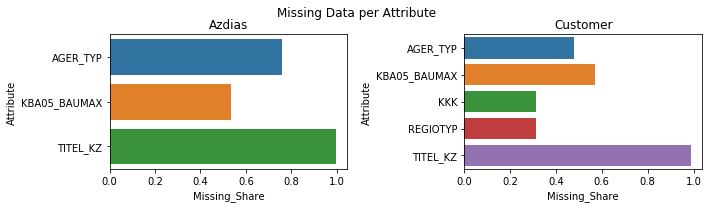

In [28]:
compare_missing_share_plot(azdias_missing_share, customers_missing_share, threshold=0.3, figsize=(10,3))

In [29]:
# list with column names to drop
removed_features_azdias = azdias_missing_share[azdias_missing_share['Missing_Share'] >= 0.3].Attribute.tolist()
removed_features_customers = customers_missing_share[customers_missing_share['Missing_Share'] >= 0.3].Attribute.tolist()
removed_features = removed_features_azdias + removed_features_customers

# drop column names from azdias and customer (create new dfs as backup)
azdias_2 = azdias.drop(removed_features, axis = 1)
customers_2 = customers.drop(removed_features, axis = 1)

Next, I also want to remove rows with too many missing values. Therefore, I will look at the distribution of rows per number of missing features. I will then choose a threshold of missing values per row. Rows with too many missing values will then be removed.

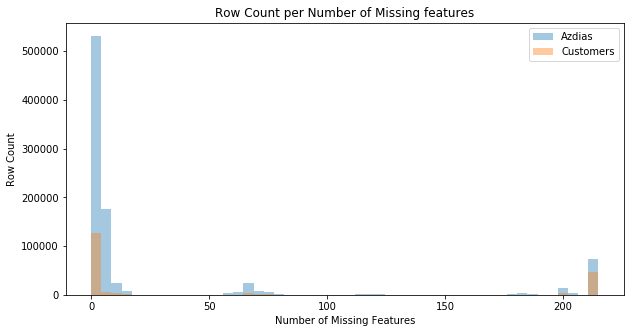

In [25]:
# Plot distribution of Row Count per Number of Missing Features
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set_title("Row Count per Number of Missing features")
ax.set_xlabel("Number of Missing Features")
ax.set_ylabel("Row Count")
sns.distplot(azdias.isnull().sum(axis=1), 50, kde=False, ax=ax, label="Azdias")
sns.distplot(customers.isnull().sum(axis=1), 50, kde=False, ax=ax, label="Customers")
ax.legend()
plt.show()

The chart shows that the vast majority of rows have less than 50 missing features for both data sets. Also, a good chunk of rows have even 200 missing values or more. Therefore, I will remove every row with more than 50 missing values. 

In [26]:
# Remove rows with more than 50 missing values
azdias_2 = azdias_2.dropna(thresh=azdias_2.shape[1]-50)
customers_2 = customers_2.dropna(thresh=customers_2.shape[1]-50)

### 0.4 Categorical Values

In [27]:
# How many categorical columns are there?
print(azdias_2.info())
print(customers_2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 737288 entries, 1 to 891220
Columns: 267 entries, ALTER_HH to ALTERSKATEGORIE_GROB
dtypes: float64(217), int64(48), object(2)
memory usage: 1.5+ GB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 134246 entries, 0 to 191651
Columns: 267 entries, ALTER_HH to ALTERSKATEGORIE_GROB
dtypes: float64(217), int64(48), object(2)
memory usage: 274.5+ MB
None


In [28]:
# Print object colmns
print(azdias_2.columns[azdias_2.dtypes == "object"])
print(customers_2.columns[customers_2.dtypes == "object"])

Index(['CAMEO_DEU_2015', 'OST_WEST_KZ'], dtype='object')
Index(['CAMEO_DEU_2015', 'OST_WEST_KZ'], dtype='object')


In [29]:
# Print unique values
print(azdias_2['CAMEO_DEU_2015'].unique())
print(azdias_2['OST_WEST_KZ'].unique())

['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '7A' '5D' '9E' '5C' '9B'
 '1B' '8B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6E' '6D' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C'
 'XX']
['W' 'O']


The first feature (CAMEO_DEU_2015) has a high number of unique values. This granularity would result in too many new features when converted to dummy variables. Hence, I will remove this feature.

The second feature (OST_WEST_KZ) will be converted to a binary feature.

In [31]:
# Remove feature
azdias_2 = azdias.drop(['CAMEO_DEU_2015'], axis = 1)
customers_2 = customers.drop(['CAMEO_DEU_2015'], axis = 1)

In [32]:
# Convert to binary
azdias_2["OST_WEST_KZ"] = azdias_2["OST_WEST_KZ"].replace({"W": 0, "O": 1})
customers_2["OST_WEST_KZ"] = customers_2["OST_WEST_KZ"].replace({"W": 0, "O": 1})

### 0.5 Imputing missing values

Next, I am going to impute the left missing values with the mode of each feature (~ the most common value).

In [33]:
# Imputing the mode
imputation = Imputer(strategy="most_frequent")
azdias_3 = pd.DataFrame(imputation.fit_transform(azdias_2), columns = azdias_2.columns)
customers_3 = pd.DataFrame(imputation.transform(customers_2), columns = customers_2.columns)

In [34]:
# Check if all null values are imputed
azdias_3.isnull().sum(axis = 0)

AGER_TYP                      0
ALTER_HH                      0
ANZ_HAUSHALTE_AKTIV           0
ANZ_HH_TITEL                  0
ANZ_PERSONEN                  0
ANZ_TITEL                     0
BALLRAUM                      0
CAMEO_DEUG_2015               0
CJT_GESAMTTYP                 0
D19_BANKEN_ANZ_12             0
D19_BANKEN_ANZ_24             0
D19_BANKEN_DATUM              0
D19_BANKEN_OFFLINE_DATUM      0
D19_BANKEN_ONLINE_DATUM       0
D19_BANKEN_ONLINE_QUOTE_12    0
D19_GESAMT_ANZ_12             0
D19_GESAMT_ANZ_24             0
D19_GESAMT_DATUM              0
D19_GESAMT_OFFLINE_DATUM      0
D19_GESAMT_ONLINE_DATUM       0
D19_GESAMT_ONLINE_QUOTE_12    0
D19_KONSUMTYP                 0
D19_TELKO_ANZ_12              0
D19_TELKO_ANZ_24              0
D19_TELKO_DATUM               0
D19_TELKO_OFFLINE_DATUM       0
D19_TELKO_ONLINE_DATUM        0
D19_VERSAND_ANZ_12            0
D19_VERSAND_ANZ_24            0
D19_VERSAND_DATUM             0
                             ..
PLZ8_BAU

### 0.6 Feature Scaling

Now I am going to scale the features in order to make sure that all feature contribute equally to the results.

In [37]:
# Scaling the features
scaling = MinMaxScaler()
scaling.fit(azdias_3)
azdias_scaled = pd.DataFrame(scaling.transform(azdias_3), columns = azdias_3.columns)
customers_scaled = pd.DataFrame(scaling.transform(customers_3), columns = customers_3.columns)

In [39]:
# Save data
azdias_scaled.to_csv('Azdias_scaled.csv', index=False)
customers_scaled.to_csv('Customers_scaled.csv', index=False)

In [25]:
# Import scaled data
#azdias_scaled = pd.read_csv('./Azdias_scaled.csv')
#customers_scaled = pd.read_csv('./Customers_scaled.csv')

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [27]:
# due to too large data resulting in enormous processing times I picked samples of azdias and customers (large enough)
azdias_scaled_sample = azdias_scaled.sample(n=200000, random_state=123)
customers_scaled_sample = customers_scaled.sample(n=100000, random_state=123)

### 1.1 Dimensionality Reduction

Due to the high number of features, the goal here is to reduce these to only include the most meaningful ones. To determine the number of features I am going to use the azdias data which covers the population.

In [29]:
# Function for building the pca model
def build_pca_model(df, n_components=None):
    ''' This function takes the data and number of components
    and returns the PCA model and transformed data '''
    pca = PCA(n_components)
    df_transformed = pca.fit_transform(df)
    return pca, df_transformed

In [30]:
# Building the pca model
azdias_pca_model, azdias_pca_transformed = build_pca_model(azdias_scaled_sample)

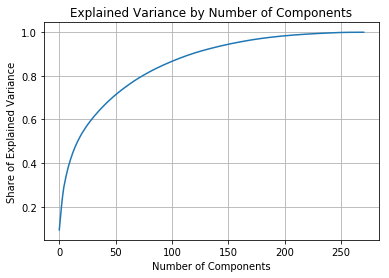

In [31]:
# Function to plot the share of explained variance by number of components
def plot_explained_variance(pca_mdl):
    ''' This function takes the pca model and plots the explained variance by the number of components '''
    explained_variance = np.cumsum(pca_mdl.explained_variance_ratio_)
    plt.plot(explained_variance)
    plt.xlabel('Number of Components')
    plt.ylabel('Share of Explained Variance')
    plt.title('Explained Variance by Number of Components')
    plt.grid(b=True)
    plot = plt.show()

# Plot    
plot_explained_variance(azdias_pca_model)

Based on the chart I can conclude that rougly 125 components explain about 90% of the variance. Therefore, I will continue modelling with 125 components.

In [32]:
# Build PCA model with 125 components and return transformed data
azdias_pca_model, azdias_pca_transformed_125components = build_pca_model(azdias_scaled_sample, 125)
customers_pca_model, customers_pca_transformed_125components = build_pca_model(customers_scaled_sample, 125)

### 1.2 Customer Segmentation

Next we are going to choose a suitable number of clusters and then finally cluster the data. 

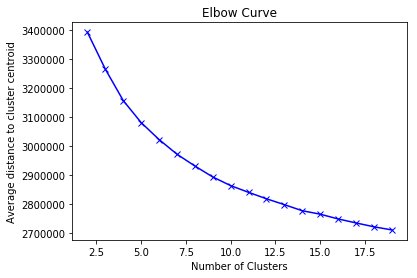

In [33]:
# Function to plot the elbow curve
def plot_elbow_curve(df, cluster_range=range(2,20)):
    ''' This function takes the provided data 
    and plots the average distance to the cluster centroid
    for an increasing number of clusters 
    in order to determine the most suitable number of clusters
    '''
    points = np.array([])
    K = cluster_range
    for k in K:      
        kmeans = KMeans(k)
        km = kmeans.fit(df)
        points = np.append(points, np.abs(km.score(df))) 
    plt.plot(K, points, 'bx-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Average distance to cluster centroid')
    plt.title('Elbow Curve')
    plt.show()

# Plot
plot_elbow_curve(azdias_pca_transformed_125components)

Based on the elbow chart, 9 clusters seems to be a reasonable number of clusters. Next we are going to cluster the data.

In [34]:
# Function to train kmeans model
def kmeans_modelling(df, clusters):
    ''' This function takes the provided data and returns a kmeans model and the kmeans transformed data '''
    kmeans_mdl = KMeans(clusters, random_state=123)
    kmeans_predictions = kmeans_mdl.fit_predict(df)
    return kmeans_mdl, kmeans_predictions

# Cluster data
azdias_kmeans_model, azdias_kmeans_predictions = kmeans_modelling(azdias_pca_transformed_125components, 9)
customers_kmeans_model, customers_kmeans_predictions = kmeans_modelling(customers_pca_transformed_125components, 9)

### 1.3 Segmentation Results

Lastly, we are going analyse the clusters and compare the general population with the customer base. 

   Azdias  Customers  azdias_share  customers_share
0   18438      10668         0.092            0.107
1   15958      24254         0.080            0.243
2   18063       6578         0.090            0.066
3   29733       6572         0.149            0.066
4   20673      11701         0.103            0.117
5   16839       9960         0.084            0.100
6   24852      10511         0.124            0.105
7   25516       9097         0.128            0.091
8   29928      10659         0.150            0.107


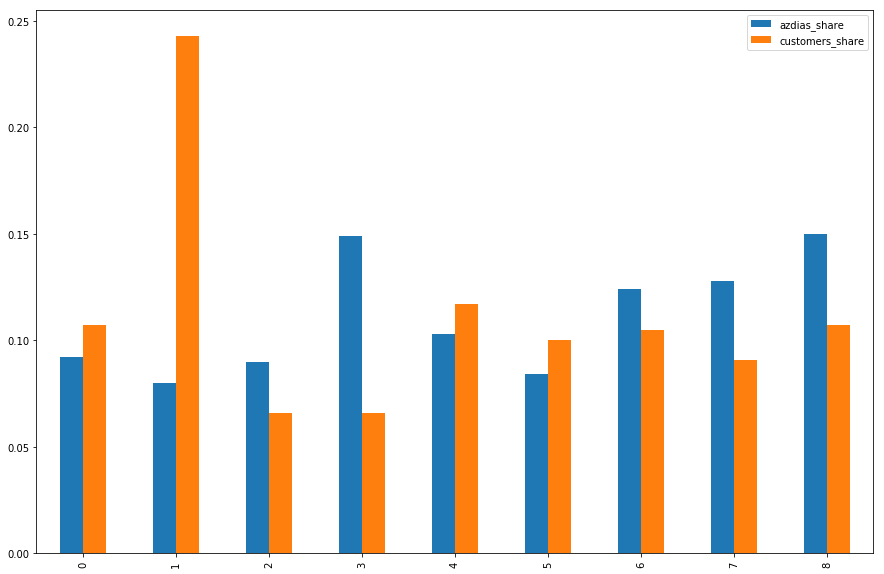

In [35]:
# Compare cluster attribution between poplaton and customers
azdias_kmeans_predictions = pd.Series(azdias_kmeans_predictions, name='Azdias')
customers_kmeans_predictions = pd.Series(customers_kmeans_predictions, name='Customers')

clusters_data = pd.concat([azdias_kmeans_predictions.value_counts().sort_index(), 
                         customers_kmeans_predictions.value_counts().sort_index()], axis=1)

clusters_data = clusters_data.assign(azdias_share=lambda x: round((x.Azdias / clusters_data.Azdias.sum()),3))
clusters_data = clusters_data.assign(customers_share=lambda x: round((x.Customers / clusters_data.Customers.sum()),3))

# Print results
print(clusters_data)

# Plot results
clusters_data[['azdias_share', 'customers_share']].plot(figsize=(15,10), kind = 'bar')

Based on the chart we can clearly see that those in the population that are placed in cluster 1 are more likely to be Arvato customers, compared to the rest of the clusters. Those in the population that are placed in cluster 3 on the other hand are however seem to be less likely to become Arvato customers.

In [36]:
# Function to describe clusters
def cluster_description(df, pca_mdl, kmeans_mdl, cluster_n):
    ''' This function takes the data, pca model, kmeans model, chosen cluster 
    and returns the cluster centres for each feature '''
    
    cluster_dict = dict(zip(df.columns, pca_mdl.inverse_transform(kmeans_mdl.cluster_centers_[cluster_n])))
    cluster_description = pd.DataFrame.from_dict(cluster_dict, orient='index', columns=[cluster_n])
    
    # select specific features that are easy to interpret the cluster
    features = ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'OST_WEST_KZ', 'BALLRAUM', 'CAMEO_DEUG_2015', 'D19_BANKEN_ANZ_12',
              'D19_VERSI_ANZ_12', 'EWDICHTE', 'FINANZTYP', 'KBA13_ANZAHL_PKW', 'KBA13_KRSZUL_NEU', 'LP_FAMILIE_FEIN',
               'LP_LEBENSPHASE_FEIN', 'LP_STATUS_FEIN', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP']
    cluster_description = cluster_description.loc[features]
    
    return cluster_description

In [37]:
# apply cluster description function to describe clusters based on selected features
cluster_table = cluster_description(customers_scaled_sample, customers_pca_model, customers_kmeans_model, 0)
for k in range(1,9):
    cluster_info = cluster_description(customers_scaled_sample, customers_pca_model, customers_kmeans_model, k)
    cluster_table = cluster_table.join(cluster_info)
cluster_table

,0,1,2,3,4,5,6,7,8
ALTERSKATEGORIE_GROB,0.314709,0.089407,0.275453,0.314470,0.332919,0.300592,0.295102,0.328857,0.319958
ANREDE_KZ,0.520560,0.518538,0.429443,0.330946,-0.000798,0.191092,0.293920,1.002497,0.034715
OST_WEST_KZ,0.163971,0.001516,0.166576,0.042023,0.032693,0.032962,0.094459,0.052951,0.052318
BALLRAUM,0.408922,0.833085,0.449159,0.303861,0.524549,0.485963,0.755539,0.633578,0.748201
CAMEO_DEUG_2015,0.742528,0.875171,0.682027,0.307616,0.318572,0.276581,0.344890,0.380751,0.418232
D19_BANKEN_ANZ_12,0.003907,0.000197,0.034406,0.017188,0.008418,0.044654,0.046469,0.006536,0.005708
D19_VERSI_ANZ_12,0.005406,-0.000594,0.028302,0.017903,0.016130,0.035331,0.047630,0.013038,0.019500
EWDICHTE,0.829682,0.996442,0.808101,0.817667,0.628340,0.634840,0.282565,0.500221,0.348663
FINANZTYP,0.698477,0.596437,0.628910,0.707564,0.672361,0.666719,0.659925,0.488336,0.574642
KBA13_ANZAHL_PKW,0.259336,0.604216,0.297869,0.254834,0.305637,0.311136,0.313287,0.318943,0.330461


### The Typical Customer
Based on cluster 1, the typical customer of Arvato has the following features
- is relatively young and lives in a single household
- is from West Germany
- is either male or female (no gender preference)
- is from the working class and lives in a low class, high population density neighbourhood
- has a relatively low online affinity
- has a relatively low banking transaction acitivity and a rather low financial interest

Cluster 3 is largely the opposite of this description. Parts of the population that are placed in cluster 3 are less likely to be Arvato customers.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [44]:
# Load in the data
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# Inspect data
mailout_train.head(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3
5,1789,3,1.0,12.0,NaN,NaN,NaN,NaN,12.0,17.0,...,2.0,1.0,1.0,6.0,9.0,2.0,3,0,2,3
6,1795,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,2.0,...,6.0,6.0,3.0,6.0,9.0,2.0,3,0,2,4
7,1493,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,1.0,1.0,6.0,9.0,7.0,3,0,2,4
8,1801,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,0,2,3
9,1834,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,0,1,1


### 2.1 Evaluation Metric

In [6]:
# Check response balance
mailout_train.RESPONSE.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

Accuracy is the most common evaluation metric. However, the training data shows that the response is highly skewed as the vast majority of targeted customers did not convert following the campaign. 

In this case, we will evaluate the performance using AUC (Area under curve; or AUROC); which is more suitable for unbalanced responses.

### 2.2 Data Preparation

In [ ]:
# Function to prepare data based on data cleaning in section 0
def data_cleaning (df):
    
    # handle warning
    warning_columns = ['CAMEO_INTL_2015', 'CAMEO_DEUG_2015']
    df[warning_columns] = df[warning_columns].replace(['X', 'XX'], np.NaN).astype(float)
    
    # Use same columns as in previous analysis
    #cols = common_columns | {'RESPONSE'} | {'LNR'}
    #df = df[df.columns.intersection(cols)]
    
    # replace unknowns with nans
    df = replace_unknown_values(df, attributes_values_unknown)
    
    # removing columns which have been previously identified as having too many missing values
    df = df.drop(removed_features, axis = 1)
    
    # remove rows with too many missing values
    df = df.dropna(thresh=df.shape[1]-100)
    
    # handling categorical variables
    df = df.drop(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM'], axis = 1)
    df["OST_WEST_KZ"] = df["OST_WEST_KZ"].replace({"W": 0, "O": 1})
    
    # imputing missing values with mode
    imputation = Imputer(strategy="most_frequent")
    df = pd.DataFrame(imputation.fit_transform(df), columns = df.columns)
    
    # return df
    return df

mailout_train = data_cleaning(mailout_train)

In [47]:
# Inspect data after cleaning
print(mailout_train.shape)
mailout_train.head(10)

(35000, 359)


,LNR,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763.0,1.0,8.0,18.0,17.0,18.0,13.0,8.0,15.0,0.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3.0,0.0,2.0,4.0
1,1771.0,4.0,13.0,18.0,17.0,18.0,13.0,13.0,1.0,0.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1.0,0.0,2.0,3.0
2,1776.0,1.0,9.0,18.0,17.0,18.0,13.0,7.0,0.0,0.0,...,6.0,4.0,2.0,6.0,9.0,2.0,3.0,0.0,1.0,4.0
3,1460.0,1.0,6.0,18.0,17.0,18.0,13.0,6.0,4.0,0.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3.0,0.0,2.0,4.0
4,1783.0,1.0,9.0,18.0,17.0,18.0,13.0,9.0,53.0,0.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3.0,0.0,1.0,3.0
5,1789.0,1.0,12.0,18.0,17.0,18.0,13.0,12.0,17.0,0.0,...,2.0,1.0,1.0,6.0,9.0,2.0,3.0,0.0,2.0,3.0
6,1795.0,1.0,8.0,18.0,17.0,18.0,13.0,8.0,2.0,0.0,...,6.0,6.0,3.0,6.0,9.0,2.0,3.0,0.0,2.0,4.0
7,1493.0,1.0,13.0,18.0,17.0,18.0,13.0,13.0,1.0,0.0,...,1.0,1.0,1.0,6.0,9.0,7.0,3.0,0.0,2.0,4.0
8,2512.0,1.0,8.0,18.0,17.0,18.0,13.0,8.0,2.0,0.0,...,7.0,8.0,5.0,6.0,9.0,7.0,3.0,0.0,1.0,4.0
9,2513.0,1.0,15.0,18.0,17.0,18.0,13.0,8.0,1.0,0.0,...,1.0,1.0,1.0,3.0,9.0,4.0,3.0,0.0,2.0,4.0


We lost about 8k rows (19%) of the training data due to a large number of missing values. However, the data now is clean and ready to be used for modelling. 

In [ ]:
# Save cleaned
mailout_train.to_csv('mailout_train_clean.csv', index=False)

In [46]:
# Import cleaned data
#mailout_train = pd.read_csv('./mailout_train_clean.csv')

In [10]:
# Check response balance
mailout_train.RESPONSE.value_counts()

0.0    34565
1.0      435
Name: RESPONSE, dtype: int64

### 2.3 Training Base Model

In [11]:
# Labels, prediction features and LNR 
labels = mailout_train['RESPONSE']
mailout_train_x = mailout_train.drop(['RESPONSE', 'LNR'], axis = 1)

In [12]:
# Split train data
X_train, X_val, Y_train, Y_val = train_test_split(mailout_train_x, labels, stratify=labels, test_size=0.3, random_state=123)

In [13]:
# Train data with simple logistic regression model as base model
LR = LogisticRegression(random_state=123)
LR.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=123, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [14]:
# Predict using base model
predictions = LR.predict_proba(X_val)[:,1]

# Calculating AUC
roc_auc_score(Y_val, predictions)

0.68106075216972028

### 2.4 Improve Model

#### 2.4.1 Scaling data

In [15]:
# Scaling data
scaling = MinMaxScaler()
mailout_train_x_scaled = pd.DataFrame(scaling.fit_transform(mailout_train_x), columns = mailout_train_x.columns)

#### 2.4.2 Choosing the best classifier

In [16]:
# Splitting data
X_train, X_val, Y_train, Y_val = train_test_split(mailout_train_x_scaled, labels, stratify=labels, test_size=0.3, random_state=123)

In [19]:
# Function to train model and predict
def train_predict(model, X_train, Y_train, X_val, Y_val):
    """ Trains a model, predicts on test data and returns AUC score"""
    
    model = model.fit(X_train, Y_train)
    auc_score = roc_auc_score(Y_val, model.predict_proba(X_val)[:,1])
    
    return auc_score

In [22]:
# List different advanced classifiers to test
mdls = [("LogisticRegression", LogisticRegression(random_state=123)),
        ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=123)),
        ("RandomForestClassifier", RandomForestClassifier(random_state=123)),
        ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=123)),
        ("AdaBoostClassifier", AdaBoostClassifier(random_state=123))]

# Test different classifiers
performance = {"Model":[],
               "AUC_score":[]}

for name, mdl in mdls:
    auc = train_predict(mdl, X_train, Y_train, X_val, Y_val)
    performance["Model"].append(name)
    performance["AUC_score"].append(auc)

In [23]:
# Compare results
performance = pd.DataFrame.from_dict(performance, orient='index').transpose()
performance

,Model,AUC_score
0,LogisticRegression,0.686586
1,DecisionTreeClassifier,0.499303
2,RandomForestClassifier,0.526515
3,GradientBoostingClassifier,0.772798
4,AdaBoostClassifier,0.753984


The Gradient Boosting Classifier performs best. Therefore, we will continue with this classifier.

#### 2.4.3 Grid Search

In [42]:
# Grid Search (Gradient Boost)
param_grid = {"n_estimators": [100,150],
              "learning_rate": [0.1,0.5,1.],
              }

gradientboost_gridsearch = GridSearchCV(estimator = GradientBoostingClassifier(random_state=123), 
                                   param_grid = param_grid, 
                                   scoring = "roc_auc", 
                                   cv = 4, n_jobs = -1, verbose=2)

gradientboost_gridsearch.fit(X_train, Y_train)

gradientboost_best = gradientboost_gridsearch.best_estimator_

print("Best AUC Score: ", gradientboost_gridsearch.best_score_)
print("Best Params: ", gradientboost_gridsearch.best_params_)

Fitting 4 folds for each of 6 candidates, totalling 24 fits
[CV] learning_rate=0.1, n_estimators=100 .............................
[CV] .............. learning_rate=0.1, n_estimators=100, total=  25.7s
[CV] learning_rate=0.1, n_estimators=100 .............................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   25.9s remaining:    0.0s


[CV] .............. learning_rate=0.1, n_estimators=100, total=  24.6s
[CV] learning_rate=0.1, n_estimators=100 .............................
[CV] .............. learning_rate=0.1, n_estimators=100, total=  25.1s
[CV] learning_rate=0.1, n_estimators=100 .............................
[CV] .............. learning_rate=0.1, n_estimators=100, total=  25.0s
[CV] learning_rate=0.1, n_estimators=150 .............................
[CV] .............. learning_rate=0.1, n_estimators=150, total=  36.1s
[CV] learning_rate=0.1, n_estimators=150 .............................
[CV] .............. learning_rate=0.1, n_estimators=150, total=  36.3s
[CV] learning_rate=0.1, n_estimators=150 .............................
[CV] .............. learning_rate=0.1, n_estimators=150, total=  36.3s
[CV] learning_rate=0.1, n_estimators=150 .............................
[CV] .............. learning_rate=0.1, n_estimators=150, total=  36.6s
[CV] learning_rate=0.5, n_estimators=100 .............................
[CV] .

[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 10.8min finished


Best AUC Score:  0.768404409099
Best Params:  {'learning_rate': 0.1, 'n_estimators': 100}


### 2.5 Final model

In [48]:
# Make predictions
predictions_gradientboost = gradientboost_best.predict_proba(X_val)[:,1]

# Calculate AUC
roc_auc_score(Y_val, predictions_gradientboost)

0.77279801201691267

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [49]:
# Load in test data
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [50]:
# Function to prepare test data (requires slight modification to previous version)
def data_cleaning_2 (df):
    
    # handle warning
    warning_columns = ['CAMEO_INTL_2015', 'CAMEO_DEUG_2015']
    df[warning_columns] = df[warning_columns].replace(['X', 'XX'], np.NaN).astype(float)
    
    # Use same columns as in previous analysis
    #cols = common_columns | {'RESPONSE'} | {'LNR'}
    #df = df[df.columns.intersection(cols)]
    
    # replace unknowns with nans
    df = replace_unknown_values(df, attributes_values_unknown)
    
    # removing columns which have been previously identified as having too many missing values
    df = df.drop(removed_features, axis = 1)
    
    # handling categorical variables
    df = df.drop(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM'], axis = 1)
    df["OST_WEST_KZ"] = df["OST_WEST_KZ"].replace({"W": 0, "O": 1})
    
    # imputing missing values with mode
    imputation = Imputer(strategy="most_frequent")
    df = pd.DataFrame(imputation.fit_transform(df), columns = df.columns)
    
    # return df
    return df

In [ ]:
# Cleaning test data
mailout_test = data_cleaning_2(mailout_test)
mailout_test_LNR = mailout_test["LNR"]
mailout_test_x = mailout_test.drop(['LNR'], axis = 1)
mailout_test_x_scaled = pd.DataFrame(scaling.fit_transform(mailout_test_x), columns = mailout_test_x.columns)

In [52]:
# Fit final model
gradientboost_best.fit(mailout_train_x_scaled, labels)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=123, subsample=1.0, verbose=0,
              warm_start=False)

In [ ]:
# Output predictions
gradientboost_test_predictions = gradientboost_best.predict_proba(mailout_test_x_scaled)[:,1]
kaggle_predictions = pd.DataFrame(index=mailout_test_LNR, data=gradientboost_test_predictions)
kaggle_predictions.rename(columns={0: "RESPONSE"}, inplace=True)
kaggle_predictions.reset_index(level=0, inplace=True)
kaggle_predictions['LNR'] = kaggle_predictions['LNR'].astype(int)
kaggle_predictions.to_csv('Kaggle_submission.csv', index=False)